## 导入包

In [30]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from gensim.models import Word2Vec
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier as cat
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error, precision_recall_curve, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
from sklearn.pipeline import Pipeline

from tqdm import tqdm
from datetime import datetime
import sys
import os
import gc
import argparse
import warnings
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE # 导入tsne包
from sklearn.decomposition import PCA, KernelPCA # PCA
from sklearn.manifold import Isomap # Isomap
from sklearn.impute import KNNImputer

In [31]:
import gc
import pandas as pd
import numpy as np 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
# 相关全局设置
pd.set_option('display.max_columns', None)
sns.set()
import warnings
warnings.filterwarnings('ignore')

## 数据读取和基本处理

In [32]:
# 读取疾病特征数据集（训练集）
disease_feature1 = pd.read_csv("./data/train/disease_feature1.csv")
disease_feature2 = pd.read_csv("./data/train/disease_feature2.csv")
disease_feature3 = pd.read_csv("./data/train/disease_feature3.csv")

# 读取 train_food 和 train_answer（训练集）
train_food = pd.read_csv("./data/train/train_food.csv")
train_answer = pd.read_csv("./data/train/train_answer.csv")

# 读取 A榜 测试集数据（测试集）
preliminary_a_food = pd.read_csv("./data/test_A/preliminary_a_food.csv")
preliminary_a_submit_sample = pd.read_csv("./data/test_A/preliminary_a_submit_sample.csv")

In [33]:
# 删除测试集标签列
del preliminary_a_submit_sample["related"]

In [34]:
# 拼接标签数据（将包含标签的训练集和没有标签的测试集拼接）
data = pd.concat([train_answer, preliminary_a_submit_sample], axis=0).reset_index(drop=True)
data.head()

,food_id,disease_id,related
0,food_0,disease_998,0.0
1,food_0,disease_861,0.0
2,food_0,disease_559,0.0
3,food_0,disease_841,0.0
4,food_0,disease_81,0.0


In [35]:
# 拼接食物数据（将训练集食物数据和测试集食物数据拼接）
food = pd.concat([train_food, preliminary_a_food], axis=0).reset_index(drop=True)
food.head()

,food_id,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19,N_20,N_21,N_22,N_23,N_24,N_25,N_26,N_27,N_28,N_29,N_30,N_31,N_32,N_33,N_34,N_35,N_36,N_37,N_38,N_39,N_40,N_41,N_42,N_43,N_44,N_45,N_46,N_47,N_48,N_49,N_50,N_51,N_52,N_53,N_54,N_55,N_56,N_57,N_58,N_59,N_60,N_61,N_62,N_63,N_64,N_65,N_66,N_67,N_68,N_69,N_70,N_71,N_72,N_73,N_74,N_75,N_76,N_77,N_78,N_79,N_80,N_81,N_82,N_83,N_84,N_85,N_86,N_87,N_88,N_89,N_90,N_91,N_92,N_93,N_94,N_95,N_96,N_97,N_98,N_99,N_100,N_101,N_102,N_103,N_104,N_105,N_106,N_107,N_108,N_109,N_110,N_111,N_112,N_113,N_114,N_115,N_116,N_117,N_118,N_119,N_120,N_121,N_122,N_123,N_124,N_125,N_126,N_127,N_128,N_129,N_130,N_131,N_132,N_133,N_134,N_135,N_136,N_137,N_138,N_139,N_140,N_141,N_142,N_143,N_144,N_145,N_146,N_147,N_148,N_149,N_150,N_151,N_152,N_153,N_154,N_155,N_156,N_157,N_158,N_159,N_160,N_161,N_162,N_163,N_164,N_165,N_166,N_167,N_168,N_169,N_170,N_171,N_172,N_173,N_174,N_175,N_176,N_177,N_178,N_179,N_180,N_181,N_182,N_183,N_184,N_185,N_186,N_187,N_188,N_189,N_190,N_191,N_192,N_193,N_194,N_195,N_196,N_197,N_198,N_199,N_200,N_201,N_202,N_203,N_204,N_205,N_206,N_207,N_208,N_209,N_210,N_211
0,food_0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,32.0,NaN,NaN,2.10,NaN,6.0,87.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,14.4,NaN,NaN,NaN,NaN,0.157,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,0.056,0.409,0.069,NaN,NaN,NaN,NaN,NaN,NaN,1.9,NaN,36.0,36.0,36.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.96,NaN,NaN,NaN,NaN,0.0,0.0,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0.056,NaN,0.000,NaN,0.0,NaN,NaN,0.481,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,79.0,NaN,3.99,0.234,NaN,NaN,NaN,NaN,0.175,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.126,0.6,NaN,0.0,NaN,0.000,NaN,0.002,NaN,0.059,NaN,0.008,NaN,NaN,NaN,NaN,0.000,0.0,0.000,6.0,NaN,NaN,NaN,0.20,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,NaN,NaN,8.0,0.0,0.0,0.034,8.2,0.0,NaN,NaN,NaN,NaN,0.02,0.0,NaN,NaN,30.5,92.82,NaN,0.92
1,food_1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,268.0,NaN,NaN,21.01,NaN,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,52.1,NaN,NaN,NaN,NaN,1.099,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,598.0,NaN,NaN,NaN,NaN,NaN,33.076,12.955,4.092,NaN,NaN,NaN,NaN,NaN,NaN,10.9,NaN,55.0,55.0,55.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.73,NaN,NaN,NaN,NaN,1.0,0.0,NaN,279.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259,NaN,NaN,NaN,32.754,NaN,0.007,NaN,0.0,NaN,NaN,3.637,NaN,NaN,NaN,NaN,471.0,NaN,NaN,NaN,NaN,713.0,NaN,20.96,12.945,NaN,NaN,NaN,NaN,0.010,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,1.197,2.0,NaN,0.0,NaN,0.000,NaN,0.019,NaN,3.348,NaN,0.704,NaN,NaN,NaN,NaN,0.000,0.0,0.000,3.0,NaN,NaN,NaN,4.86,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.54,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.136,0.0,0.0,NaN,NaN,NaN,NaN,23.90,0.0,NaN,NaN,0.0,2.41,NaN,3.31
2,food_4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,62.0,NaN,NaN,79.32,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,11.1,NaN,NaN,NaN,NaN,0.272,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,299.0,NaN,NaN,NaN,NaN,NaN,0.024,0.053,0.094,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,5.0,5.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.79,NaN,NaN,NaN,NaN,0.0,0.0,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN,NaN,0.023,NaN,0.000,NaN,0.0,NaN,NaN,0.766,NaN,NaN,NaN,NaN,98.0,NaN,NaN,NaN,NaN,744.0,NaN,3.30,0.039,NaN,NaN,NaN,NaN,0.014,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.125,0.6,NaN,0.0,NaN,0.001,NaN,0.004,NaN,0.056,NaN,0.013,NaN,NaN,NaN,NaN,0.007,0.0,0.001,26.0,NaN,NaN,NaN,65.18,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.174,2.3,0.0,NaN,NaN,NaN,NaN,0.12,0.0,NaN,NaN,3.5,15.46,NaN,0.36
3,food_5,NaN,NaN,NaN,0.068,0.0,0.045,0.75,0.314,NaN,NaN,NaN,NaN,NaN,0.0,1

## 对food_id和disease_id进行编码

In [36]:
data["food"] = data["food_id"].apply(lambda x: int(x.split("_")[-1]))
data["disease"] = data["disease_id"].apply(lambda x: int(x.split("_")[-1]))                        

## 目标编码
本题只有两个离散变量 food_id 和 disease_id ，而测试集中都是新的food_id

In [37]:
cat_list = ['disease']
def stat(df, df_merge, group_by, agg):
    group = df.groupby(group_by).agg(agg)

    columns = []
    for on, methods in agg.items():
        for method in methods:
            columns.append('{}_{}_{}'.format('_'.join(group_by), on, method))
    group.columns = columns
    group.reset_index(inplace=True)
    df_merge = df_merge.merge(group, on=group_by, how='left')

    del (group)
    gc.collect()
    return df_merge

def statis_feat(df_know, df_unknow,cat_list):
    for f in tqdm(cat_list):
        df_unknow = stat(df_know, df_unknow, [f], {'related': ['mean']})

    return df_unknow


df_train = data[~data['related'].isnull()]
df_train = df_train.reset_index(drop=True)
df_test = data[data['related'].isnull()]

df_stas_feat = None
kf = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
for train_index, val_index in kf.split(df_train, df_train['related']):
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_val = statis_feat(df_fold_train, df_fold_val,cat_list)
    df_stas_feat = pd.concat([df_stas_feat, df_fold_val], axis=0)

    del (df_fold_train)
    del (df_fold_val)
    gc.collect()

df_test = statis_feat(df_train, df_test,cat_list)
data = pd.concat([df_stas_feat, df_test], axis=0)
data = data.reset_index(drop=True)

del (df_stas_feat)
del (df_train)
del (df_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


0

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


0

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


0

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.48it/s]


0

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


0

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s]


## 疾病特征处理

### 缺失值填充0

In [38]:
disease_feature1 = disease_feature1.fillna(0)
disease_feature2 = disease_feature2.fillna(0)
disease_feature3 = disease_feature3.fillna(0)

### 降维前归一化

In [39]:
def standard_disease(df):
    """
    降维前归一化
    """
    std = MinMaxScaler()
    disease_id_array = df["disease_id"]
    cols = [f for f in df.columns if f not in ["disease_id"]]
    df_std = std.fit_transform(df[cols])
    df_temp = pd.DataFrame(data = df_std[0:, 0:], columns = cols)
    df_disease_id = pd.DataFrame(data=disease_id_array, columns = ["disease_id"])
    df = pd.concat([df_disease_id, df_temp], axis=1)
    return df
disease_feature1 = standard_disease(disease_feature1)
disease_feature2 = standard_disease(disease_feature2)
disease_feature3 = standard_disease(disease_feature3)

### PCA降维

In [40]:
## PCA 对疾病特征数据集进行降维处理 
def pca(df):
    disease_id_array = df["disease_id"]
    df_pca = PCA(n_components=min(df.shape[0], df.shape[1])).fit_transform(df.iloc[:, 1:])
    df_temp = pd.DataFrame(data=df_pca[0:, 0:], columns = [ "F_" + str(item) for item in range(df_pca.shape[1])])
    df_disease_id = pd.DataFrame(data=disease_id_array, columns = ["disease_id"])
    df_disease = pd.concat([df_disease_id, df_temp], axis=1)
    print(df_disease.shape)
    return df_disease

# pca
df_disease1 = pca(disease_feature1)
df_disease2 = pca(disease_feature2)
df_disease3 = pca(disease_feature3)

(220, 221)
(301, 302)
(392, 393)


### 数据合并

In [41]:
data = pd.merge(data, food, on="food_id", how="left")
data = pd.merge(data, df_disease1, on="disease_id", how="left")
data = pd.merge(data, df_disease2, on="disease_id", how="left")
data = pd.merge(data, df_disease3, on="disease_id", how="left")
data.head()

,food_id,disease_id,related,food,disease,disease_related_mean,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19,N_20,N_21,N_22,N_23,N_24,N_25,N_26,N_27,N_28,N_29,N_30,N_31,N_32,N_33,N_34,N_35,N_36,N_37,N_38,N_39,N_40,N_41,N_42,N_43,N_44,N_45,N_46,N_47,N_48,N_49,N_50,N_51,N_52,N_53,N_54,N_55,N_56,N_57,N_58,N_59,N_60,N_61,N_62,N_63,N_64,N_65,N_66,N_67,N_68,N_69,N_70,N_71,N_72,N_73,N_74,N_75,N_76,N_77,N_78,N_79,N_80,N_81,N_82,N_83,N_84,N_85,N_86,N_87,N_88,N_89,N_90,N_91,N_92,N_93,N_94,N_95,N_96,N_97,N_98,N_99,N_100,N_101,N_102,N_103,N_104,N_105,N_106,N_107,N_108,N_109,N_110,N_111,N_112,N_113,N_114,N_115,N_116,N_117,N_118,N_119,N_120,N_121,N_122,N_123,N_124,N_125,N_126,N_127,N_128,N_129,N_130,N_131,N_132,N_133,N_134,N_135,N_136,N_137,N_138,N_139,N_140,N_141,N_142,N_143,N_144,N_145,N_146,N_147,N_148,N_149,N_150,N_151,N_152,N_153,N_154,N_155,N_156,N_157,N_158,N_159,N_160,N_161,N_162,N_163,N_164,N_165,N_166,N_167,N_168,N_169,N_170,N_171,N_172,N_173,N_174,N_175,N_176,N_177,N_178,N_179,N_180,N_181,N_182,N_183,N_184,N_185,N_186,N_187,N_188,N_189,N_190,N_191,N_192,N_193,N_194,N_195,N_196,N_197,N_198,N_199,N_200,N_201,N_202,N_203,N_204,N_205,N_206,N_207,N_208,N_209,N_210,N_211,F_0_x,F_1_x,F_2_x,F_3_x,F_4_x,F_5_x,F_6_x,F_7_x,F_8_x,F_9_x,F_10_x,F_11_x,F_12_x,F_13_x,F_14_x,F_15_x,F_16_x,F_17_x,F_18_x,F_19_x,F_20_x,F_21_x,F_22_x,F_23_x,F_24_x,F_25_x,F_26_x,F_27_x,F_28_x,F_29_x,F_30_x,F_31_x,F_32_x,F_33_x,F_34_x,F_35_x,F_36_x,F_37_x,F_38_x,F_39_x,F_40_x,F_41_x,F_42_x,F_43_x,F_44_x,F_45_x,F_46_x,F_47_x,F_48_x,F_49_x,F_50_x,F_51_x,F_52_x,F_53_x,F_54_x,F_55_x,F_56_x,F_57_x,F_58_x,F_59_x,F_60_x,F_61_x,F_62_x,F_63_x,F_64_x,F_65_x,F_66_x,F_67_x,F_68_x,F_69_x,F_70_x,F_71_x,F_72_x,F_73_x,F_74_x,F_75_x,F_76_x,F_77_x,F_78_x,F_79_x,F_80_x,F_81_x,F_82_x,F_83_x,F_84_x,F_85_x,F_86_x,F_87_x,F_88_x,F_89_x,F_90_x,F_91_x,F_92_x,F_93_x,F_94_x,F_95_x,F_96_x,F_97_x,F_98_x,F_99_x,F_100_x,F_101_x,F_102_x,F_103_x,F_104_x,F_105_x,F_106_x,F_107_x,F_108_x,F_109_x,F_110_x,F_111_x,F_112_x,F_113_x,F_114_x,F_115_x,F_116_x,F_117_x,F_118_x,F_119_x,F_120_x,F_121_x,F_122_x,F_123_x,F_124_x,F_125_x,F_126_x,F_127_x,F_128_x,F_129_x,F_130_x,F_131_x,F_132_x,F_133_x,F_134_x,F_135_x,F_136_x,F_137_x,F_138_x,F_139_x,F_140_x,F_141_x,F_142_x,F_143_x,F_144_x,F_145_x,F_146_x,F_147_x,F_148_x,F_149_x,F_150_x,F_151_x,F_152_x,F_153_x,F_154_x,F_155_x,F_156_x,F_157_x,F_158_x,F_159_x,F_160_x,F_161_x,F_162_x,F_163_x,F_164_x,F_165_x,F_166_x,F_167_x,F_168_x,F_169_x,F_170_x,F_171_x,F_172_x,F_173_x,F_174_x,F_175_x,F_176_x,F_177_x,F_178_x,F_179_x,F_180_x,F_181_x,F_182_x,F_183_x,F_184_x,F_185_x,F_186_x,F_187_x,F_188_x,F_189_x,F_190_x,F_191_x,F_192_x,F_193_x,F_194_x,F_195_x,F_196_x,F_197_x,F_198_x,F_199_x,F_200_x,F_201_x,F_202_x,F_203_x,F_204_x,F_205_x,F_206_x,F_207_x,F_208_x,F_209_x,F_210_x,F_211_x,F_212_x,F_213_x,F_214_x,F_215_x,F_216_x,F_217_x,F_218_x,F_219_x,F_0_y,F_1_y,F_2_y,F_3_y,F_4_y,F_5_y,F_6_y,F_7_y,F_8_y,F_9_y,F_10_y,F_11_y,F_12_y,F_13_y,F_14_y,F_15_y,F_16_y,F_17_y,F_18_y,F_19_y,F_20_y,F_21_y,F_22_y,F_23_y,F_24_y,F_25_y,F_26_y,F_27_y,F_28_y,F_29_y,F_30_y,F_31_y,F_32_y,F_33_y,F_34_y,F_35_y,F_36_y,F_37_y,F_38_y,F_39_y,F_40_y,F_41_y,F_42_y,F_43_y,F_44_y,F_45_y,F_46_y,F_47_y,F_48_y,F_49_y,F_50_y,F_51_y,F_52_y,F_53_y,F_54_y,F_55_y,F_56_y,F_57_y,F_58_y,F_59_y,F_60_y,F_61_y,F_62_y,F_63_y,F_64_y,F_65_y,F_66_y,F_67_y,F_68_y,F_69_y,F_70_y,F_71_y,F_72_y,F_73_y,F_74_y,F_75_y,F_76_y,F_77_y,F_78_y,F_79_y,F_80_y,F_81_y,F_82_y,F_83_y,F_84_y,F_85_y,F_86_y,F_87_y,F_88_y,F_89_y,F_90_y,F_91_y,F_92_y,F_93_y,F_94_y,F_95_y,F_96_y,F_97_y,F_98_y,F_99_y,F_100_y,F_101_y,F_102_y,F_103_y,F_104_y,F_105_y,F_106_y,F_107_y,F_108_y,F_109_y,F_110_y,F_111_y,F_112_y,F_113_y,F_114_y,F_115_y,F_116_y,F_117_y,F_118_y,F_119_y,F_120_y,F_121_y,F_122_y,F_123_y,F_124_y,F_125_y,F_126_y,F_127_y,F_128_y,F_129_y,F_130_y,F_131_y,F_132_y,F_133_y,F_134_y,F_135_y,F_136_y,F_137_y,F_138_y,F_139_y,F_140_y,F_141_y,F_142_y,F_143_y,F_144_y,F_145_y,F_146_y,F_147_y,F_148_y,F_149_y,F_150_y,F_151_y,F_152_y,F_153_y,F_15

In [13]:
# data.to_csv("./genrate_data/data.csv")

## 特征工程

### 特征交叉
按照特征重要性选取重要性靠前的特征进行交叉（跑一遍特征，选取重要的做EDA分析，特征交叉）
选择多了会过拟合 选择少效果也不佳

In [42]:
topn = ["N_33", "N_42", "N_74", "N_209", "disease", "food"] 
for i in range(len(topn)):
    for j in range(i+1, len(topn)):
        data[f"{topn[i]}+{topn[j]}"] = data[topn[i]] + data[topn[j]]
        data[f"{topn[i]}-{topn[j]}"] = data[topn[i]] - data[topn[j]]
        data[f"{topn[i]}*{topn[j]}"] = data[topn[i]] * data[topn[j]]
        data[f"{topn[i]}/{topn[j]}"] = data[topn[i]] / (data[topn[j]]+1e-5)

### 重要特征分箱处理（根据EDA结果）

#### N_14

In [15]:
# def get_N_14_seg(x):
#     if x >=0 and x <= 80:
#         return 0
#     elif x > 80 and x <= 250:
#         return 1
#     elif x > 250 and x <= np.max(data["N_14"]):
#         return 2
# data["N14_seg"] = data["N_14"].apply(lambda x: get_N_14_seg(x))

#### N_33

In [43]:
def get_N_33_seg(x):
    if x >=0 and x <= 0.125:
        return 0
    elif x > 0.125 and x <= 1.25:
        return 1
    elif x > 1.25 and x <= np.max(data["N_33"]):
        return 2
data["N33_seg"] = data["N_33"].apply(lambda x: get_N_33_seg(x))

#### N_74

In [44]:
def get_N_74_seg(x):
    if x >=0 and x <= 2:
        return 0
    elif x > 2 and x <= np.max(data["N_74"]):
        return 1
data["N74_seg"] = data["N_74"].apply(lambda x: get_N_74_seg(x))

#### N_42

In [45]:
def get_N_42_seg(x):
    if x >=0 and x <= 500:
        return 0
    elif x > 500 and x <= 1000:
        return 1
    elif x > 1000 and x <= np.max(data["N_42"]):
        return 2
data["N42_seg"] = data["N_42"].apply(lambda x: get_N_42_seg(x))

#### N_60

In [19]:
# def get_N_60_seg(x):
#     if x >=0 and x <= 30:
#         return 0
#     elif x > 30 and x <= 150:
#         return 1
#     elif x > 150 and x <= np.max(data["N_60"]):
#         return 2
# data["N60_seg"] = data["N_60"].apply(lambda x: get_N_60_seg(x))

#### N_61

In [20]:
# def get_N_61_seg(x):
#     if x >=0 and x <= 30:
#         return 0
#     elif x > 30 and x <= 150:
#         return 1
#     elif x > 150 and x <= np.max(data["N_61"]):
#         return 2
# data["N61_seg"] = data["N_61"].apply(lambda x: get_N_61_seg(x))

#### food

In [46]:
data['food_qcut'] = pd.qcut(data['food'], 10, labels = False, duplicates='drop')

#### disease

In [47]:
data['disease_qcut'] = pd.qcut(data['disease'], 14, labels = False, duplicates='drop')

#### disease_related_mean

In [23]:
# data['disease_related_mean_qcut'] = pd.qcut(data['disease_related_mean'], 10, labels = False, duplicates='drop')

#### N_209

In [48]:
data['N_209_qcut'] = pd.qcut(data['N_209'], 10, labels = False, duplicates='drop')

In [49]:
drop_cols = ["disease_id", "food_id", "related"]

## 特征筛选

### 去除只有单一取值的特征

In [50]:
for col in data.columns:
    if data[col].nunique() < 2:
        drop_cols.append(col)

### 删除缺失率过高的特征

In [51]:
# 还是不删除缺失率过高的特征，否则分数会下降？
def dropNaN(df, p, col):
    na_sum = df[col].isna().sum()
    percent_value = na_sum / len(df[col])
    if percent_value >= p:
        df = df.drop([col], axis=1)
    return df
for c in data.columns:
    data = dropNaN(data, 0.95, c)

In [52]:
df_test = data[data["related"].isnull() == True].copy().reset_index(drop=True)
df_train = data[~data["related"].isnull() == True].copy().reset_index(drop=True)

In [53]:
features_name = [f for f in df_train.columns if f not in drop_cols]
x_train = df_train[features_name].reset_index(drop=True)
x_test = df_test[features_name].reset_index(drop=True)
y = df_train["related"].reset_index(drop=True)
print(len(features_name))

1109


In [24]:
features_name_b = pickle.load(open("./temp_files/feat", "rb"))

In [28]:
feat = list((set(features_name).intersection(set(features_name_b))))

In [29]:
for item in features_name_b:
    if item not in feat:
        print(item)

N_29
N_31
N_189


## 模型训练

In [25]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2023
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
#     skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    oof = np.zeros(train_x.shape[0]) # 初始化一个大小为n（n=训练集行数），值全为0的数组 用于存放每折验证集的预测概率
    predict = np.zeros(test_x.shape[0]) # 初始化一个大小为n（n=测试集行数），值全为0的数组 用于存放预测概率

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y) # 该折训练集矩阵
            valid_matrix = clf.Dataset(val_x, label=val_y) # 该折验证集矩阵

            params = {
                'learning_rate': 0.01,
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'num_leaves': 63,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'seed': 2022,
                'bagging_seed': 1,
                'feature_fraction_seed': 7,
                'min_data_in_leaf': 20,
                'verbose': -1, 
                'n_jobs':8
            }
            # 模型训练 valid_sets也可以只放valid_matrix verbose_eval表示打印信息的间隔 early_stopping_rounds表示早停，
            # 防止过拟合，表示在验证集上,当连续n次迭代,分数没有提高后,提前终止训练
            model = clf.train(params, train_matrix, 100000, valid_sets=[train_matrix, valid_matrix], 
                              categorical_feature=[], verbose_eval=100, early_stopping_rounds=500) 
            val_pred = model.predict(val_x, num_iteration=model.best_iteration) # 预测该折验证集 最优迭代次数
            test_pred = model.predict(test_x, num_iteration=model.best_iteration) # 该折训练下的模型来预测测试集
            
#             print(list(sorted(zip(cols, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y) # 该折该折训练集矩阵
            valid_matrix = clf.DMatrix(val_x , label=val_y) # 该折验证集矩阵
            test_matrix = clf.DMatrix(test_x) # 测试集矩阵
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.05,
                      'seed': 2020,
                      'nthread': 8,
                      'gpu_id':0,
                      'tree_method':'gpu_hist'
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            # num_boost_round为迭代次数 evals是一个列表，用于对训练过程中进行评估列表中的元素，形式就是watchlist
            model = clf.train(params, train_matrix, num_boost_round=10000, evals=watchlist, verbose_eval=100, early_stopping_rounds=500)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit) # 最优模型时对应树的个数
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            
            model = clf(
            n_estimators=10000,
            random_seed=1024,
            eval_metric='AUC',
            learning_rate=0.05,
            max_depth=5,
            early_stopping_rounds=500,
            metric_period=500,
            task_type='GPU'
                    )

            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      use_best_model=True,
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)[:,1]
            test_pred = model.predict_proba(test_x)[:,1]
            
        oof[valid_index] = val_pred # 将每一折验证集的预测结果放入原先的初始化矩阵中（每一折会对应索引valid_index）
        
        predict += test_pred / folds # ？
        
        
        cv_scores.append(roc_auc_score(val_y, val_pred))
        print(cv_scores)
    return oof, predict

In [31]:
# lgb模型训练
start_time = datetime.now()
lgb_oof, lgb_pred = cv_model(lgb, x_train, y, x_test, 'lgb')
end_time = datetime.now()
print(end_time - start_time)

************************************ 1 ************************************
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.957762	valid_1's auc: 0.955537
[200]	training's auc: 0.969899	valid_1's auc: 0.962202
[300]	training's auc: 0.976829	valid_1's auc: 0.967243
[400]	training's auc: 0.982195	valid_1's auc: 0.970041
[500]	training's auc: 0.985932	valid_1's auc: 0.971943
[600]	training's auc: 0.988514	valid_1's auc: 0.973354
[700]	training's auc: 0.990469	valid_1's auc: 0.974141
[800]	training's auc: 0.992079	valid_1's auc: 0.974952
[900]	training's auc: 0.993376	valid_1's auc: 0.975624
[1000]	training's auc: 0.99446	valid_1's auc: 0.976198
[1100]	training's auc: 0.995399	valid_1's auc: 0.976606
[1200]	training's auc: 0.996219	valid_1's auc: 0.977053
[1300]	training's auc: 0.996895	valid_1's auc: 0.977392
[1400]	training's auc: 0.997448	valid_1's auc: 0.977661
[1500]	training's auc: 0.997929	valid_1's auc: 0.977979
[1600]	training's auc: 0.998317	

[7500]	training's auc: 1	valid_1's auc: 0.982052
[7600]	training's auc: 1	valid_1's auc: 0.982063
[7700]	training's auc: 1	valid_1's auc: 0.982068
[7800]	training's auc: 1	valid_1's auc: 0.982074
[7900]	training's auc: 1	valid_1's auc: 0.98207
[8000]	training's auc: 1	valid_1's auc: 0.982087
[8100]	training's auc: 1	valid_1's auc: 0.982078
[8200]	training's auc: 1	valid_1's auc: 0.982108
[8300]	training's auc: 1	valid_1's auc: 0.982126
[8400]	training's auc: 1	valid_1's auc: 0.982117
[8500]	training's auc: 1	valid_1's auc: 0.982115
[8600]	training's auc: 1	valid_1's auc: 0.982143
[8700]	training's auc: 1	valid_1's auc: 0.982179
[8800]	training's auc: 1	valid_1's auc: 0.98218
[8900]	training's auc: 1	valid_1's auc: 0.982208
[9000]	training's auc: 1	valid_1's auc: 0.982187
[9100]	training's auc: 1	valid_1's auc: 0.982182
[9200]	training's auc: 1	valid_1's auc: 0.982162
[9300]	training's auc: 1	valid_1's auc: 0.982178
[9400]	training's auc: 1	valid_1's auc: 0.98218
Early stopping, best it

[5800]	training's auc: 1	valid_1's auc: 0.978494
[5900]	training's auc: 1	valid_1's auc: 0.978525
[6000]	training's auc: 1	valid_1's auc: 0.978534
[6100]	training's auc: 1	valid_1's auc: 0.978594
[6200]	training's auc: 1	valid_1's auc: 0.978589
[6300]	training's auc: 1	valid_1's auc: 0.978589
[6400]	training's auc: 1	valid_1's auc: 0.978584
[6500]	training's auc: 1	valid_1's auc: 0.978624
[6600]	training's auc: 1	valid_1's auc: 0.978613
[6700]	training's auc: 1	valid_1's auc: 0.978653
[6800]	training's auc: 1	valid_1's auc: 0.978643
[6900]	training's auc: 1	valid_1's auc: 0.97866
[7000]	training's auc: 1	valid_1's auc: 0.978707
[7100]	training's auc: 1	valid_1's auc: 0.978709
[7200]	training's auc: 1	valid_1's auc: 0.978741
[7300]	training's auc: 1	valid_1's auc: 0.978775
[7400]	training's auc: 1	valid_1's auc: 0.978787
[7500]	training's auc: 1	valid_1's auc: 0.978786
[7600]	training's auc: 1	valid_1's auc: 0.978782
[7700]	training's auc: 1	valid_1's auc: 0.978803
[7800]	training's auc

In [32]:
# pickle.dump(lgb_oof, open("./temp_files/learn_codes/lgb_oof3", "wb"))
# pickle.dump(lgb_pred, open("./temp_files/learn_codes/lgb_pred3", "wb"))

In [35]:
lgb_oof = pickle.load(open("./temp_files/learn_codes/lgb_oof2_0.9397", "rb"))
lgb_pred = pickle.load(open("./temp_files/learn_codes/lgb_pred2_0.9397", "rb"))

In [26]:
# lgb_oof = pickle.load(open("./temp_files/learn_codes/lgb_oof3", "rb"))
# lgb_pred = pickle.load(open("./temp_files/learn_codes/lgb_pred3", "rb"))

In [36]:
print("lgb train auc:", roc_auc_score(y, lgb_oof))

lgb train auc: 0.9798809559336137


## lgb xgb cat 模型融合

In [36]:
# xgb模型训练
# start_time = datetime.now()
# xgb_oof, xgb_pred = cv_model(xgb, x_train, y, x_test, 'xgb')
# end_time = datetime.now() 
# print(end_time - start_time)

In [37]:
# print("xgb train auc:", roc_auc_score(y, xgb_oof))

In [38]:
# pickle.dump(xgb_oof, open("./temp_files/learn_codes/xgb_oof", "wb"))
# pickle.dump(xgb_pred, open("./temp_files/learn_codes/xgb_pred", "wb"))

In [39]:
# # cat模型训练
# start_time = datetime.now()
# cat_oof, cat_pred = cv_model(cat, x_train, y, x_test, 'cat')
# end_time = datetime.now() 
# print(end_time - start_time)

In [40]:
# print("cat train auc:", roc_auc_score(y, cat_oof))

In [41]:
# pickle.dump(cat_oof, open("./temp_files/learn_codes/cat_oof", "wb"))
# pickle.dump(cat_pred, open("./temp_files/learn_codes/cat_pred", "wb"))

In [42]:
# oof = 1/3 * lgb_oof + 1/3 * xgb_oof + 1/3 * cat_oof
# pred = 1/3 * lgb_pred + 1/3 * xgb_pred + 1/3 * cat_pred

In [43]:
# print("fusion train auc:", roc_auc_score(y, oof))

In [44]:
# pickle.dump(oof, open("./temp_files/learn_codes/fusion_oof", "wb"))
# pickle.dump(pred, open("./temp_files/learn_codes/fusion_pred", "wb"))

## 搜索最优阈值（线下搜索阈值法）
这种方法在线下和线上不一致的时候并不适用

In [37]:
oof = lgb_oof
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.1,0.6,0.01):
    preds = (oof.reshape((-1))>threshold).astype('int')
    f = f1_score(y.values.reshape((-1)), preds, average='macro') 
    scores.append(f)
    thresholds.append(threshold)
    
    if f > best_score:
        best_score = f
        best_threshold = threshold
    print(f'{threshold:.03f}, {f}')
print("==============================")
lgb_score = best_score
print(f'{best_threshold:.03f}, {best_score}')

0.100, 0.87911940106381
0.110, 0.881842576243894
0.120, 0.8843211522010394
0.130, 0.8864900378426006
0.140, 0.8881232683672446
0.150, 0.8896477104368409
0.160, 0.8915003957231971
0.170, 0.8929989628615056
0.180, 0.8942550357035955
0.190, 0.8952175140982388
0.200, 0.8960685998140276
0.210, 0.897600618820968
0.220, 0.8985449891611379
0.230, 0.8996840930531289
0.240, 0.9002276974205633
0.250, 0.9009971899892779
0.260, 0.9016715039700735
0.270, 0.9021838142356509
0.280, 0.9032181668530684
0.290, 0.9040510086000905
0.300, 0.904210193652587
0.310, 0.9043752676202367
0.320, 0.9041737549814133
0.330, 0.9045435747922449
0.340, 0.9046649327618905
0.350, 0.9049267380726869
0.360, 0.9047594940268644
0.370, 0.9048835766645278
0.380, 0.9050526884747894
0.390, 0.9045951893502889
0.400, 0.9046349275724995
0.410, 0.9043056805749905
0.420, 0.9038192088615506
0.430, 0.9033633100954837
0.440, 0.9033729733962836
0.450, 0.9033203707108799
0.460, 0.9030358718750079
0.470, 0.9026249941668718
0.480, 0.90225791

<Figure size 1440x360 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Validation F1 Score')

Text(0.5, 1.0, 'Threshold vs. F1_Score with Best F1_Score = 0.905 at Best Threshold = 0.38')

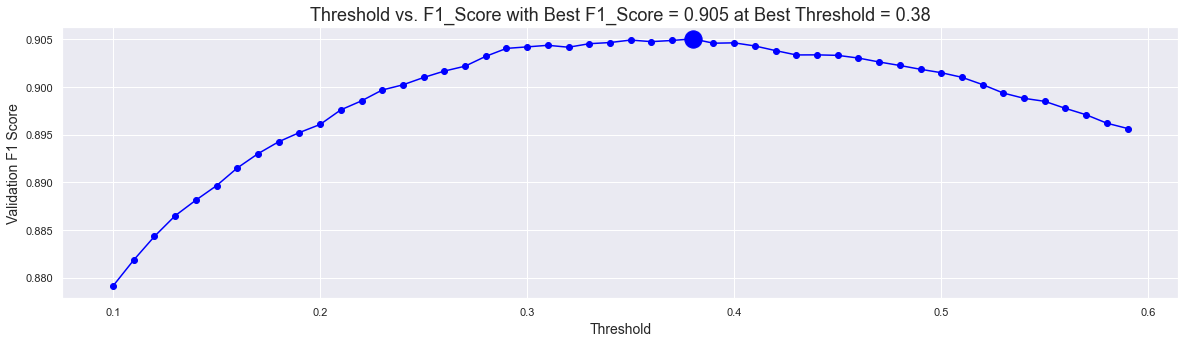

In [38]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [39]:
auc = roc_auc_score(y, oof)
f1 = best_score
print((auc + f1) / 2)

0.9424668222042015


## 结果保存

### 控制1的个数来优化结果

In [40]:
label=[1 if x >= 0.16+0.34 else 0 for x in lgb_pred+0.34]
np.sum(label)

4691

### 测试集概率后处理

In [54]:
df_test.shape

(46805, 1112)

In [41]:
df_test['related_prob'] = lgb_pred+0.34

### 保存

In [34]:
df_test[['food_id','disease_id', 'related_prob']].to_csv('./submission/submission50_3_0.29_4386.csv', index=False)